# Beer Review

In [1]:
import pandas as pd
import datetime
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from PIL import Image


def dateParse(timestamp):
    return datetime.datetime.fromtimestamp(float(timestamp))


# df = pd.read_csv('beer_reviews.csv')
df = pd.read_csv('beer_reviews.csv', parse_dates=[
                 'review_time'], date_parser=dateParse)


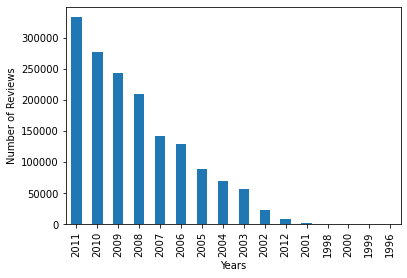

In [2]:
# Generate review year plot
df['year'] = df['review_time'].dt.year
plt.xlabel('Years')
plt.ylabel('Number of Reviews')
years = df['year'].value_counts().plot.bar(
).get_figure().savefig('review_year.png', bbox_inches='tight')


In [26]:
print(df['year'].max())
print(df['year'].min())


2012
1996


In [3]:
# Generate beer style wordcloud
beerStyles = df['beer_style'].value_counts()
bg = np.array(Image.open('beer.png'))
print(beerStyles)
wc = wordcloud.WordCloud(width=800, height=800, background_color='White', relative_scaling=.6,
                         colormap='inferno', max_words=300, prefer_horizontal=.75).generate_from_frequencies(beerStyles)
wc.to_file('stylex.jpg')


American IPA                        117586
American Double / Imperial IPA       85977
American Pale Ale (APA)              63469
Russian Imperial Stout               54129
American Double / Imperial Stout     50705
                                     ...  
Gose                                   686
Faro                                   609
Roggenbier                             466
Kvass                                  297
Happoshu                               241
Name: beer_style, Length: 104, dtype: int64


<AxesSubplot:xlabel='beer_style'>

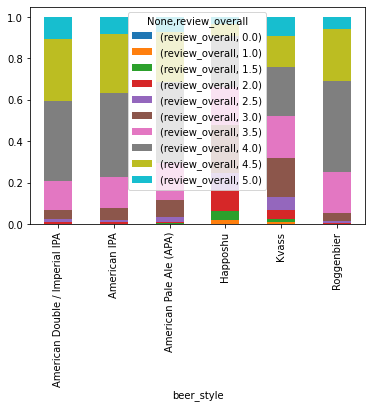

In [4]:
cond = 'beer_style=="American IPA" | beer_style=="American Double / Imperial IPA" |beer_style=="American Pale Ale (APA)" |beer_style=="Roggenbier" |beer_style=="Kvass" |beer_style=="Happoshu"'
x = df.query(cond)
gby = x.groupby(['beer_style', 'review_overall'])
sumdf = gby.agg({'review_overall': 'sum'}).groupby(
    level=0).apply(lambda x: x/float(x.sum()))
sumdf.unstack().fillna(0).plot(kind='bar', stacked=True)
#.legend(
    #bbox_to_anchor=(1.0, 1.0)).get_figure().savefig('review_dist.png', bbox_inches='tight')
# print(gby.size().unstack().fillna(0)/sumdf)


In [5]:
# preprocess
df = df.dropna()
df = pd.get_dummies(df, columns=['beer_style'])


                   review_overall  review_aroma  review_appearance  \
review_overall           1.000000      0.612793           0.498557   
review_aroma             0.612793      1.000000           0.559077   
review_appearance        0.498557      0.559077           1.000000   
review_palate            0.699020      0.614924           0.564555   
review_taste             0.787171      0.714777           0.544579   
beer_abv                 0.138457      0.332536           0.263891   

                   review_palate  review_taste  beer_abv  
review_overall          0.699020      0.787171  0.138457  
review_aroma            0.614924      0.714777  0.332536  
review_appearance       0.564555      0.544579  0.263891  
review_palate           1.000000      0.732201  0.286667  
review_taste            0.732201      1.000000  0.290782  
beer_abv                0.286667      0.290782  1.000000  


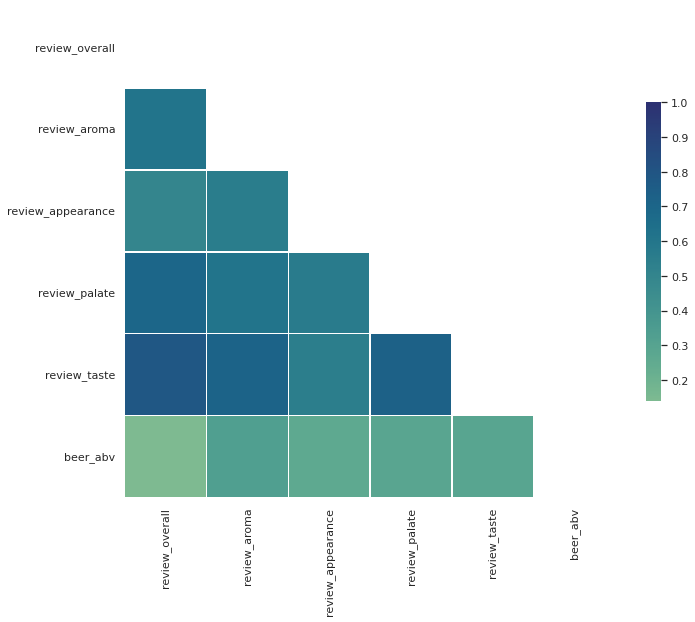

In [6]:
# Generate beer rate Bar chart
import seaborn as sns
order = ['review_overall', 'review_aroma', 'review_appearance',
         'review_palate', 'review_taste', 'beer_abv', 'review_time']
df = df[order]

sns.set_theme(style='white')
corr = df.corr()
print(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='crest', vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 50}).get_figure().savefig('corr.png')


In [8]:
# with one hot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

X = df.drop(['review_overall', 'review_time'], axis=1)
y = df['review_overall']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=225)

lasso = Lasso(alpha=0.0001, random_state=225)
result = lasso.fit(X_train, y_train)

print("Lasso train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))))
print("Lasso test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))))

print("Lasso train score："+str(result.score(X_train, y_train)))
print("Lasso test score："+str(result.score(X_test, y_test)))


Lasso train sqrt mse: 0.4117849719251423
Lasso test sqrt mse: 0.41320041669031327
Lasso train score：0.6701275709764443
Lasso test score：0.6689708911860287


In [13]:
# with one hot
from sklearn.linear_model import SGDRegressor

sgdr = SGDRegressor()
sgdr.fit(X_train, y_train)

print("sgdr train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, sgdr.predict(X_train)))))
print("sgdr test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, sgdr.predict(X_test)))))

print("sgd train score："+str(sgdr.score(X_train, y_train)))
print("sgd test score："+str(sgdr.score(X_test, y_test)))


sgdr train sqrt mse: 0.4081786981943705
sgdr test sqrt mse: 0.40953869972883195
sgd train score：0.6758800935477134
sgd test score：0.674811950292084


In [14]:
# one hot
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(max_depth=2)
tree.fit(X_train, y_train)

print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, tree.predict(X_train)))))
print("tree test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, tree.predict(X_test)))))

print("tree train score："+str(tree.score(X_train, y_train)))
print("tree test score："+str(tree.score(X_test, y_test)))


tree train sqrt mse: 0.4728708587404848
tree test sqrt mse: 0.47400569559550854
tree train score：0.5649991213429436
tree test score：0.5643759949915934


In [15]:
# one hot
from sklearn.metrics import r2_score

tree = RandomForestRegressor(max_depth=5)
tree.fit(X_train, y_train)

predTrain = tree.predict(X_train)
predTest = tree.predict(X_test)
print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, predTrain))))
print("tree test sqrt mse: " + str(np.sqrt(mean_squared_error(y_test, predTest))))

print("tree train score："+str(r2_score(y_train, predTrain)))
print("tree test score："+str(r2_score(y_test, predTest)))


tree train sqrt mse: 0.41717156366352653
tree test sqrt mse: 0.4185549770162242
tree train score：0.661440950387421
tree test score：0.6603358557358228


In [16]:
# one hot
tree = RandomForestRegressor(max_depth=10)
tree.fit(X_train, y_train)

predTrain = tree.predict(X_train)
predTest = tree.predict(X_test)
print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, predTrain))))
print("tree test sqrt mse: " + str(np.sqrt(mean_squared_error(y_test, predTest))))

print("tree train score："+str(r2_score(y_train, predTrain)))
print("tree test score："+str(r2_score(y_test, predTest)))


tree train sqrt mse: 0.4024768851505746
tree test sqrt mse: 0.40653591956370916
tree train score：0.6848720539095714
tree test score：0.6795630931909469


In [17]:
# one hot
tree = RandomForestRegressor(max_depth=20)
tree.fit(X_train, y_train)

predTrain = tree.predict(X_train)
predTest = tree.predict(X_test)
print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, predTrain))))
print("tree test sqrt mse: " + str(np.sqrt(mean_squared_error(y_test, predTest))))

print("tree train score："+str(r2_score(y_train, predTrain)))
print("tree test score："+str(r2_score(y_test, predTest)))


tree train sqrt mse: 0.3730226245076576
tree test sqrt mse: 0.40950603750998377
tree train score：0.7293080260224557
tree test score：0.6748638181116916


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

X = df.drop(['review_overall', 'review_time'], axis=1)
y = df['review_overall']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=225)

lasso = Lasso(alpha=0.0001, random_state=225)
result = lasso.fit(X_train, y_train)

print("Lasso train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))))
print("Lasso test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))))

print("Lasso train score："+str(result.score(X_train, y_train)))
print("Lasso test score："+str(result.score(X_test, y_test)))


Lasso train sqrt mse: 0.4117849719251423
Lasso test sqrt mse: 0.41320041669031327
Lasso train score：0.6701275709764443
Lasso test score：0.6689708911860287


In [38]:
from sklearn.linear_model import SGDRegressor

sgdr = SGDRegressor()
sgdr.fit(X_train, y_train)

print("sgdr train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, sgdr.predict(X_train)))))
print("sgdr test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, sgdr.predict(X_test)))))

print("sgd train score："+str(sgdr.score(X_train, y_train)))
print("sgd test score："+str(sgdr.score(X_test, y_test)))


sgdr train sqrt mse: 0.4130134548054341
sgdr test sqrt mse: 0.41440716402857597
sgd train score：0.6681564105799935
sgd test score：0.6670345339051751


In [39]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(max_depth=2)
tree.fit(X_train, y_train)

print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, tree.predict(X_train)))))
print("tree test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, tree.predict(X_test)))))

print("tree train score："+str(tree.score(X_train, y_train)))
print("tree test score："+str(tree.score(X_test, y_test)))


tree train sqrt mse: 0.4709007334403237
tree test sqrt mse: 0.4720316490264099
tree train score：0.5686162652001572
tree test score：0.5679968435209617


In [40]:
tree = RandomForestRegressor(max_depth=5)
tree.fit(X_train, y_train)

print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, tree.predict(X_train)))))
print("tree test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, tree.predict(X_test)))))

print("tree train score："+str(tree.score(X_train, y_train)))
print("tree test score："+str(tree.score(X_test, y_test)))


tree train sqrt mse: 0.41726545242183566
tree test sqrt mse: 0.4186482249661145
tree train score：0.6612885408344464
tree test score：0.6601844944333268


In [41]:
tree = RandomForestRegressor(max_depth=10)
tree.fit(X_train, y_train)

print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, tree.predict(X_train)))))
print("tree test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, tree.predict(X_test)))))

print("tree train score："+str(tree.score(X_train, y_train)))
print("tree test score："+str(tree.score(X_test, y_test)))


tree train sqrt mse: 0.403626104491344
tree test sqrt mse: 0.40730183408708165
tree train score：0.6830698725615523
tree test score：0.678354548205458


In [42]:
tree = RandomForestRegressor(max_depth=20)
tree.fit(X_train, y_train)

print("tree train sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_train, tree.predict(X_train)))))
print("tree test sqrt mse: " +
      str(np.sqrt(mean_squared_error(y_test, tree.predict(X_test)))))

print("tree train score："+str(tree.score(X_train, y_train)))
print("tree test score："+str(tree.score(X_test, y_test)))


tree train sqrt mse: 0.3806649190584089
tree test sqrt mse: 0.41676087223422625
tree train score：0.7181028123548723
tree test score：0.6632415051241276


Lasso
Lasso train sqrt mse: 0.4117849719251423
Lasso test sqrt mse: 0.41320041669031327
Lasso train score：0.6701275709764443
Lasso test score：0.6689708911860287

sgd
sgdr train sqrt mse: 0.4130134548054341
sgdr test sqrt mse: 0.41440716402857597
sgd train score：0.6681564105799935
sgd test score：0.6670345339051751

depth 2
tree train sqrt mse: 0.4709007334403237
tree test sqrt mse: 0.4720316490264099
tree train score：0.5686162652001572
tree test score：0.5679968435209617

depth 5
tree train sqrt mse: 0.41726545242183566
tree test sqrt mse: 0.4186482249661145
tree train score：0.6612885408344464
tree test score：0.6601844944333268

depth 10
tree train sqrt mse: 0.403626104491344
tree test sqrt mse: 0.40730183408708165
tree train score：0.6830698725615523
tree test score：0.678354548205458

depth 20
tree train sqrt mse: 0.3806649190584089
tree test sqrt mse: 0.41676087223422625
tree train score：0.7181028123548723
tree test score：0.6632415051241276

one hot

lasso
Lasso train sqrt mse: 0.40834474391402226
Lasso test sqrt mse: 0.40973747051743886
Lasso train score：0.6756163381386433
Lasso test score：0.6744962117734983

sgd
sgdr train sqrt mse: 0.4081786981943705
sgdr test sqrt mse: 0.40953869972883195
sgd train score：0.6758800935477134
sgd test score：0.674811950292084

depth 2
tree train sqrt mse: 0.4728708587404848
tree test sqrt mse: 0.47400569559550854
tree train score：0.5649991213429436
tree test score：0.5643759949915934

depth 5
tree train sqrt mse: 0.41717156366352653
tree test sqrt mse: 0.4185549770162242
tree train score：0.661440950387421
tree test score：0.6603358557358228

depth 10
tree train sqrt mse: 0.4024768851505746
tree test sqrt mse: 0.40653591956370916
tree train score：0.6848720539095714
tree test score：0.6795630931909469

depth 20
tree train sqrt mse: 0.3730226245076576
tree test sqrt mse: 0.40950603750998377
tree train score：0.7293080260224557
tree test score：0.6748638181116916

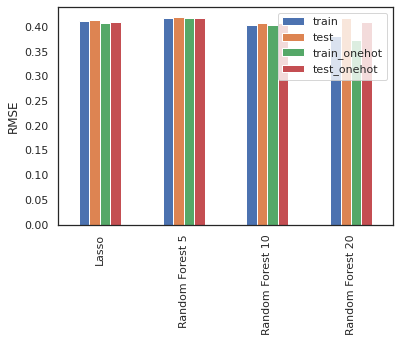

In [103]:
d = {'Lasso': [0.4117849719251423, 0.41320041669031327, 0.40834474391402226, 0.40973747051743886],
"Random Forest 5":[0.41726545242183566, 0.4186482249661145, 0.41717156366352653, 0.4185549770162242],
"Random Forest 10": [0.403626104491344, 0.40730183408708165, 0.4024768851505746, 0.40653591956370916],
"Random Forest 20": [0.3806649190584089, 0.41676087223422625, 0.3730226245076576, 0.40950603750998377]}

df1 = pd.DataFrame(data=d)
df1plt = df1.T.rename(columns={0:'train', 1:'test', 2:'train_onehot', 3:'test_onehot'}).plot(kind='bar')
df1plt.set_ylabel('RMSE')
df1plt.get_figure().savefig('mse_oh.png', bbox_inches='tight')